## Main Questions


In [373]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import numpy as np
from IPython.display import Markdown as md
import contextily as cx
import dotenv
import os

dotenv.load_dotenv()
API_KEY = os.environ["API_KEY"]

In [374]:
df = pd.read_excel(
    "311_CSR_SW.xlsx",
    dtype_backend="pyarrow",
    dtype={
        "Service Request Number": "string",
        "SR Type": "string",
        "SR Status": "string",
        "Agency": "string",
        "Created Date": "datetime64[ns]",
        "Due Date": "datetime64[ns]",
        "Close Date": "datetime64[ns]",
        "Street Address": "string",
        "Neighborhood": "string",
        "Latitude": "float",
        "Longitude": "float",
        "geo_sw_quad": "string",
    },
    date_format="%Y-%m-%d %H:%M:%S",
)

init_n = df.shape[0]

In [375]:
df = df.loc[
    ~df.loc[:, "SR Type"].str.contains("Proactive")
]  # removing "proactive" rows
df = df.loc[
    ~df.loc[:, "SR Status"].str.contains("Duplicate")
    & ~df.loc[:, "SR Status"].str.contains("Transferred")
]  # removing duplicate and trasnferred
df = df.loc[
    (df.loc[:, "Created Date"].dt.year >= 2017)
    & (df.loc[:, "Created Date"].dt.year <= 2019)
]

md(
    f"The DataFrame initially contains {init_n} rows, which after filtering as directed in the instructions reduce to {df.shape[0]} rows"
)

The DataFrame initially contains 447566 rows, which after filtering as directed in the instructions reduce to 241045 rows

**For each type of service request, how many service requests were created each year from 2017-2019?**


In [376]:
df_type_year = (
    df.groupby(["SR Type", df.loc[:, "Created Date"].dt.year])
    .size()
    .reset_index()
    .copy()
)
df_type_year.columns = ["SR Type", "Created Date", "n"]

In [377]:
df_type_year = df_type_year.pivot(columns="SR Type", index="Created Date")
df_type_year.columns = df_type_year.columns.droplevel(0)
df_type_year

SR Type,SW-Boarding,SW-Cleaning,SW-Dirty Alley,SW-Dirty Street,SW-HGW
Created Date,,,,,
2017,7445,10715,24065,15212,23488
2018,9025,16047,25936,15700,20327
2019,8007,10395,22117,13409,19157


As we can see, the numbers stay pretty constant from year-to-year. Most of them peak in 2018 (SW-Cleaning especially), while SW-HGW (High Grass and Weeds) is the only one that monotonocally decreases.


In [378]:
# df_type_year.index = pd.to_datetime(df_type_year.index, format="%Y")

# ax = df_type_year.plot(
#     kind="line",
#     title="Number of requests created by type per year (2017-2019)",
#     ylabel="Number of requests",
#     figsize=(4, 2),
# )
# ax.legend(bbox_to_anchor=(1.0, 1.0))
# ax.plot()

**How did the on-time % change over time? Please use a rolling 90 day average.**


From this graph, it is pretty clear that in 2018, the on time ratio suffered. This could potentially be due to the increase in number of requests. Throughout 2019, the on-time ratio seem to be getting slightly better, with it growing through the year although it is still not as high as the 2017-early 2018 numbers.


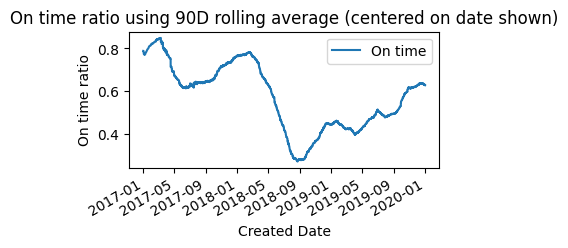

In [379]:
df.loc[:, "On time"] = df.loc[:, "Close Date"] < df.loc[:, "Due Date"]
ax = (
    df.set_index("Created Date")
    .sort_index()
    .rolling(window="90D", center=True)
    .agg({"On time": "mean"})
    .plot(
        title="On time ratio using 90D rolling average (centered on date shown)",
        ylabel="On time ratio",
        figsize=(4, 2),
    )
)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()
plt.show()

### What % of service requests created in 2019 were completed past the due date?


In [380]:
ans = (~df.loc[df.loc[:, "Created Date"].dt.year == 2019, "On time"]).mean()

In [381]:
md(
    f"The on time percentage in 2019 is {np.round(ans, 3)*100}%, which is quite low, especially compared to other time periods from the graph where it was in the late 70%s to early 80%s"
)

The on time percentage in 2019 is 51.1%, which is quite low, especially compared to other time periods from the graph where it was in the late 70%s to early 80%s

**Using the information calculated above and other information from the dataset, can you provide evidence to determine if service requests created in 2019 are being completed equitably across the city?**


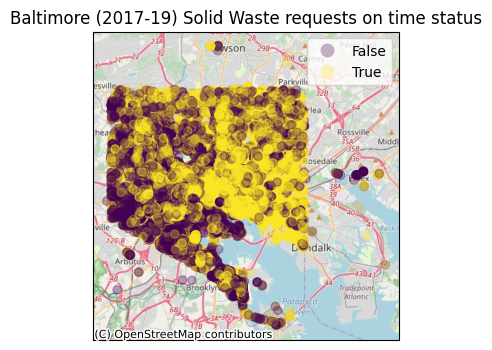

In [382]:
gs = gpd.GeoSeries.from_xy(df.loc[:, "Longitude"], df.loc[:, "Latitude"])
gdf = gpd.GeoDataFrame(df, geometry=gs).set_crs("EPSG:4326").to_crs("EPSG:3857")

fig, ax = plt.subplots(figsize=(4, 4))
gdf.cx[-8540000:-8510000, 4750000:4780000].plot(
    ax=ax, column="On time", alpha=0.3, cmap="viridis", legend=True
)

cx.add_basemap(ax, zoom=11, source=cx.providers.OpenStreetMap.Mapnik)

plt.tick_params(
    top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False
)

plt.title("Baltimore (2017-19) Solid Waste requests on time status")

plt.show()

This is a map centered on the City of Baltimore, with the points representing the filtered requests from the data. The yellow points are the ones that were serviced on time while the purple ones were not serviced on time. Clearly, there is quite a geographical split to it. The western half of the city seems to be less well serviced than the eastern half! I am not well versed with the wealth/racial split of populations across Baltimore, but I would guess it mirrors this distribution with the Eastern half being richer and Whiter.


**You may also provide any additional insights that you found while exploring the data.**


In [383]:
from census import Census
from us import states

c = Census(API_KEY)

balt_inc = pd.DataFrame(
    c.acs5.state_county_tract(
        ("NAME", "B19013_001E", "B02001_003E", "B02001_001E"),
        states.MD.fips,
        "510",
        Census.ALL,
        year=2018,
    )
)
balt_inc.loc[:, "Black Share"] = (
    balt_inc.loc[:, "B02001_003E"] / balt_inc.loc[:, "B02001_001E"]
)
md_tracts = gpd.read_file(
    "https://www2.census.gov/geo/tiger/TIGER2018/TRACT/tl_2018_24_tract.zip"
)

balt_tracts = md_tracts.loc[md_tracts.loc[:, "COUNTYFP"] == "510", :]

balt_inc_names = balt_inc.NAME.str.split(",", expand=True)
balt_inc_names.columns = ["TRACTNAME", "COUNTYNAME", "STATENAME"]
balt_inc = pd.merge(balt_inc, balt_inc_names, left_index=True, right_index=True)
balt_inc_tracts = pd.merge(
    balt_tracts, balt_inc, left_on="NAMELSAD", right_on="TRACTNAME"
)
balt_inc_tracts_SW = (
    balt_inc_tracts.to_crs(gdf.crs)
    .sjoin(gdf, how="inner", predicate="contains")
    .reset_index(drop=True)
)
balt_mean = (
    balt_inc_tracts_SW.groupby("NAMELSAD")
    .agg({"B19013_001E": "mean", "Black Share": "mean", "On time": "mean"})
    .reset_index()
)
balt_mean_tracts = pd.merge(
    balt_tracts, balt_mean, left_on="NAMELSAD", right_on="NAMELSAD"
).to_crs(gdf.crs)
balt_mean_tracts = balt_mean_tracts.loc[~(balt_mean_tracts.B19013_001E == -666666666)]

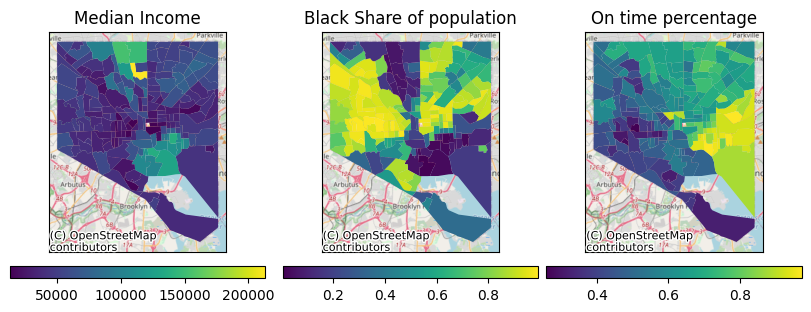

In [384]:
fig, ax = plt.subplots(1, 3, layout="constrained", figsize=(8, 3))
balt_mean_tracts.plot(
    "B19013_001E",
    ax=ax[0],
    legend=True,
    legend_kwds={"orientation": "horizontal"},
)
balt_mean_tracts.plot(
    "Black Share",
    ax=ax[1],
    legend=True,
    legend_kwds={"orientation": "horizontal"},
)
balt_mean_tracts.plot(
    "On time",
    ax=ax[2],
    legend=True,
    legend_kwds={"orientation": "horizontal"},
)

ax[0].tick_params(
    top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False
)
ax[1].tick_params(
    top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False
)
ax[2].tick_params(
    top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False
)
ax[0].set_title("Median Income")
ax[1].set_title("Black Share of population")
ax[2].set_title("On time percentage")

cx.add_basemap(ax[0], zoom=11, source=cx.providers.OpenStreetMap.Mapnik)
cx.add_basemap(ax[1], zoom=11, source=cx.providers.OpenStreetMap.Mapnik)
cx.add_basemap(ax[2], zoom=11, source=cx.providers.OpenStreetMap.Mapnik)

plt.show()

Here we use the ACS5 2018 estimates for median income and share of black population, to compare it with the on time percentage for Census Tracts in Baltimore. We see some overlap with richer, whiter areas having better service, and there is also a large swath of relatively poorer minority neighborhoods that have good service. So race and wealth do not necessarily explain the differences here!
